In [1]:
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib widget

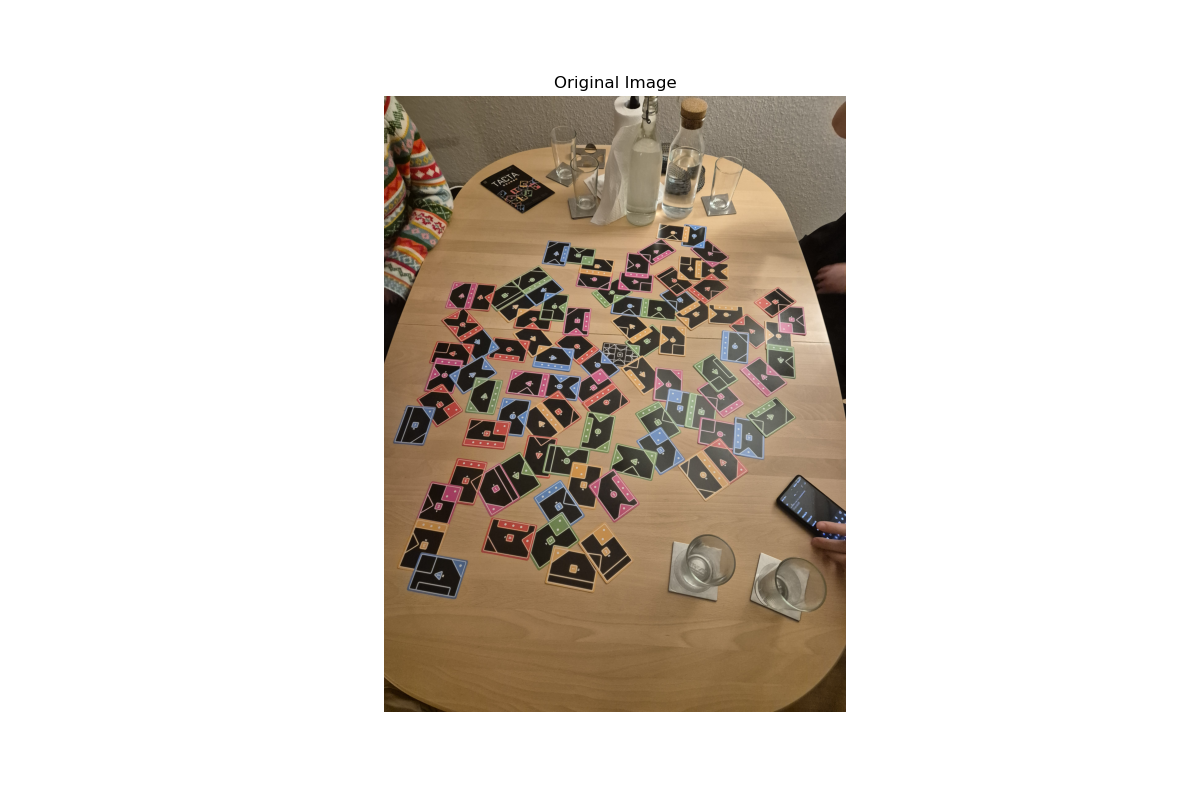

In [3]:
# Load and display the image
image_path = "data/20251106_201644.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Original Image")
plt.show()

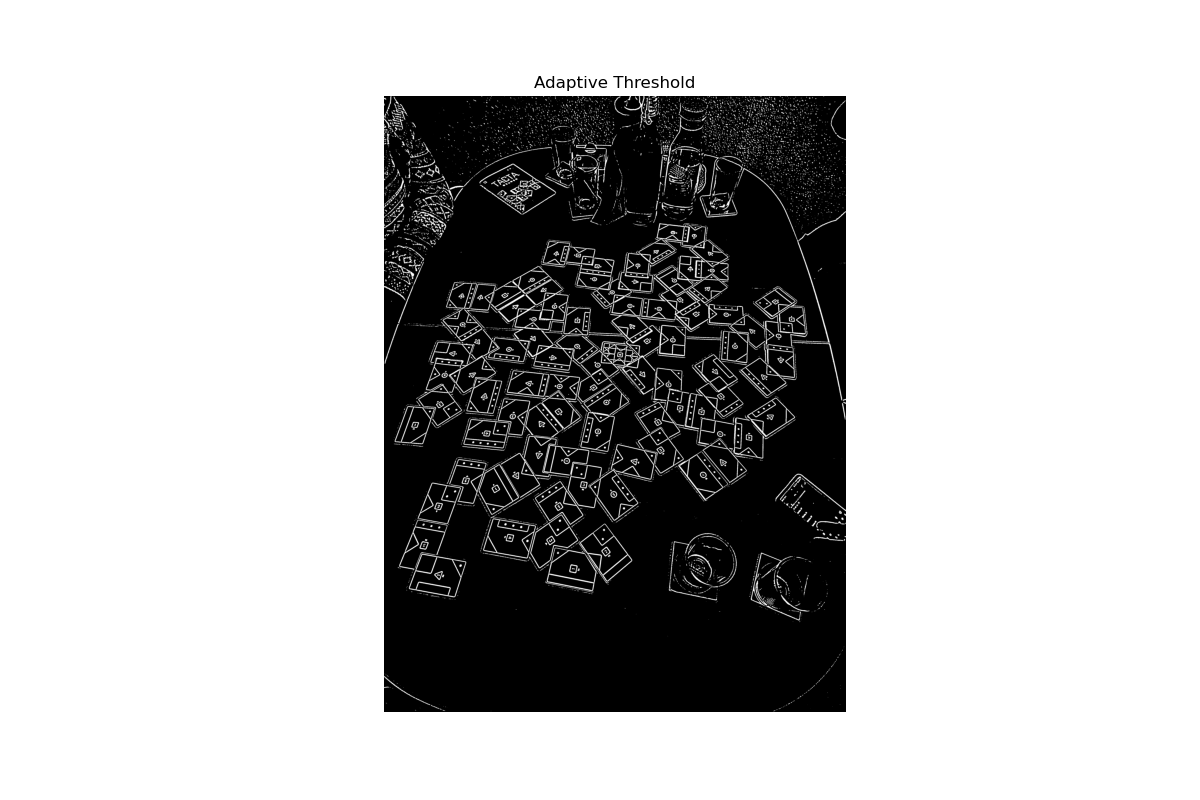

In [4]:
# Apply adaptive thresholding
blurred = cv2.GaussianBlur(gray, (11, 11), 0)
adaptive_thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, -5
)

plt.figure(figsize=(12, 8))
plt.imshow(adaptive_thresh, cmap="gray")
plt.axis("off")
plt.title("Adaptive Threshold")
plt.show()

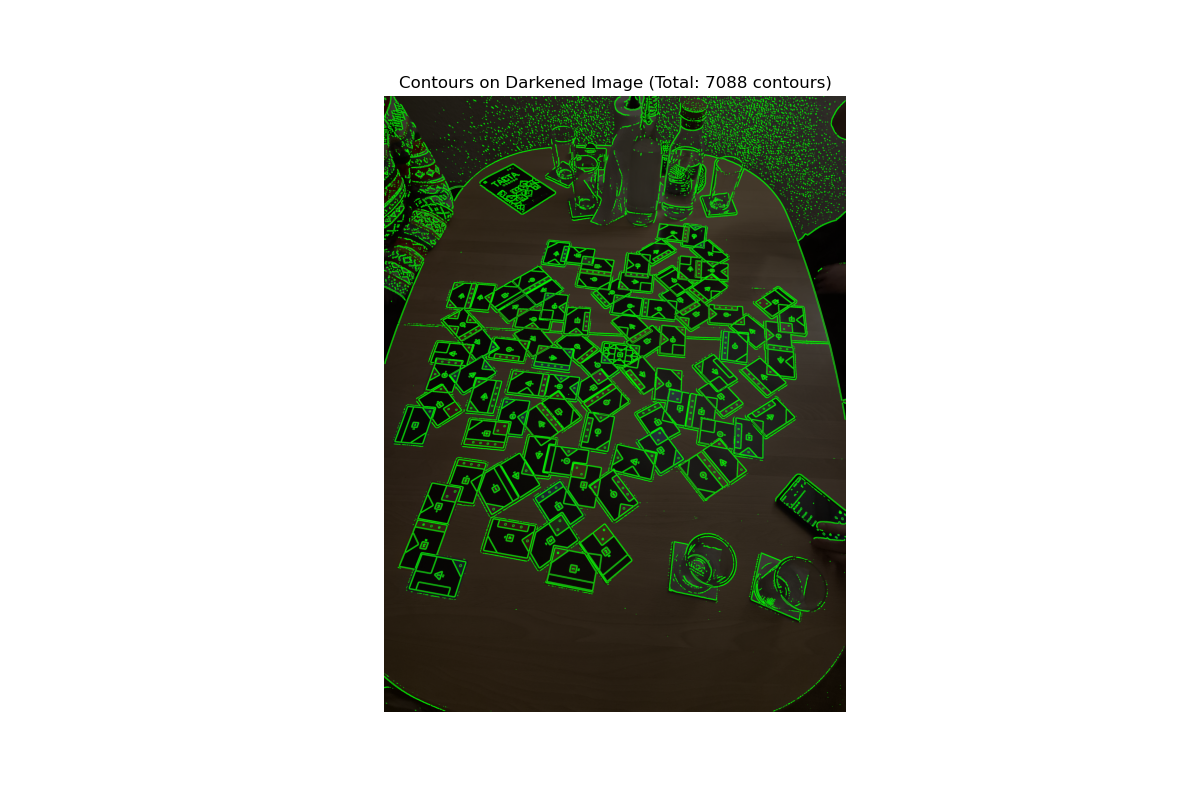

In [5]:
# Find contours

contours, hierarchy = cv2.findContours(
    adaptive_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
)

# Darken the image
darkened_image = (image_rgb * 0.3).astype(np.uint8)

# Draw contours on darkened image
contour_image = darkened_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Plot the result
plt.figure(figsize=(12, 8))
plt.imshow(contour_image)
plt.axis("off")
plt.title(f"Contours on Darkened Image (Total: {len(contours)} contours)")
plt.show()

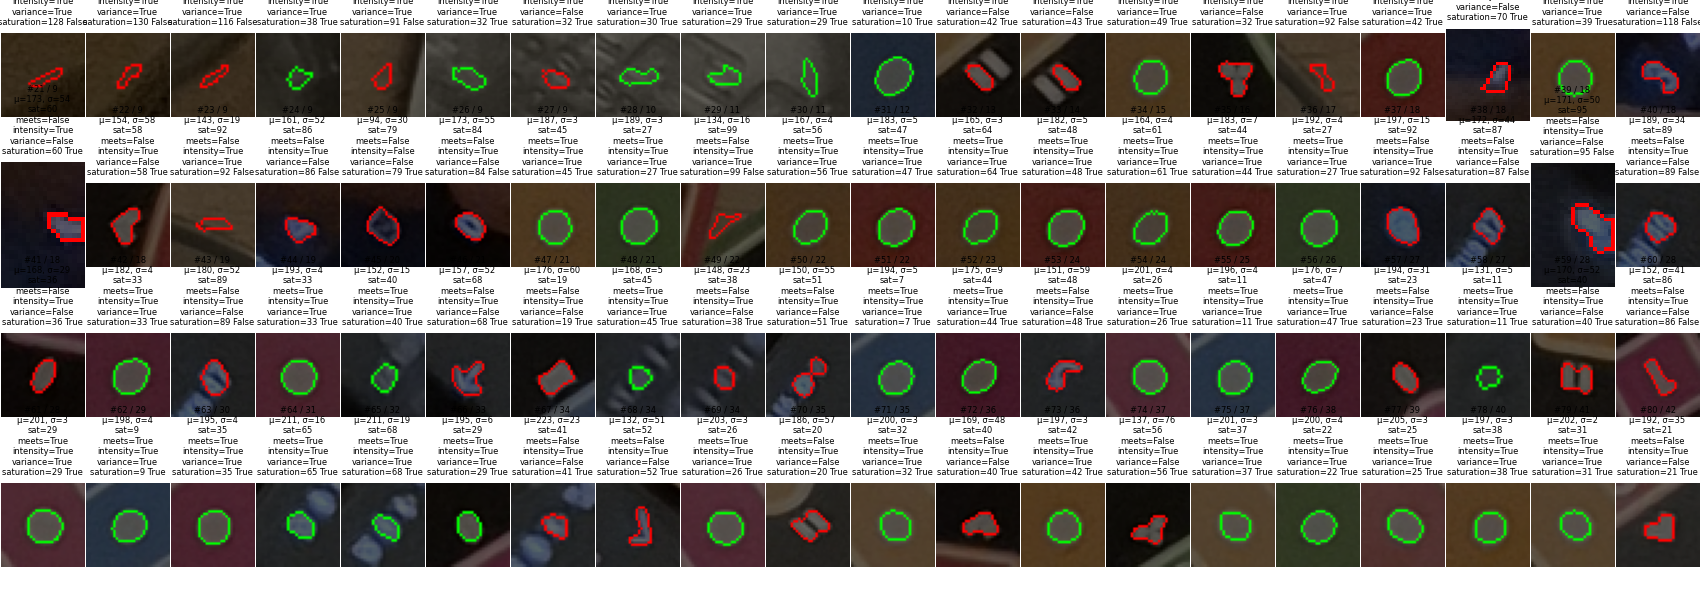

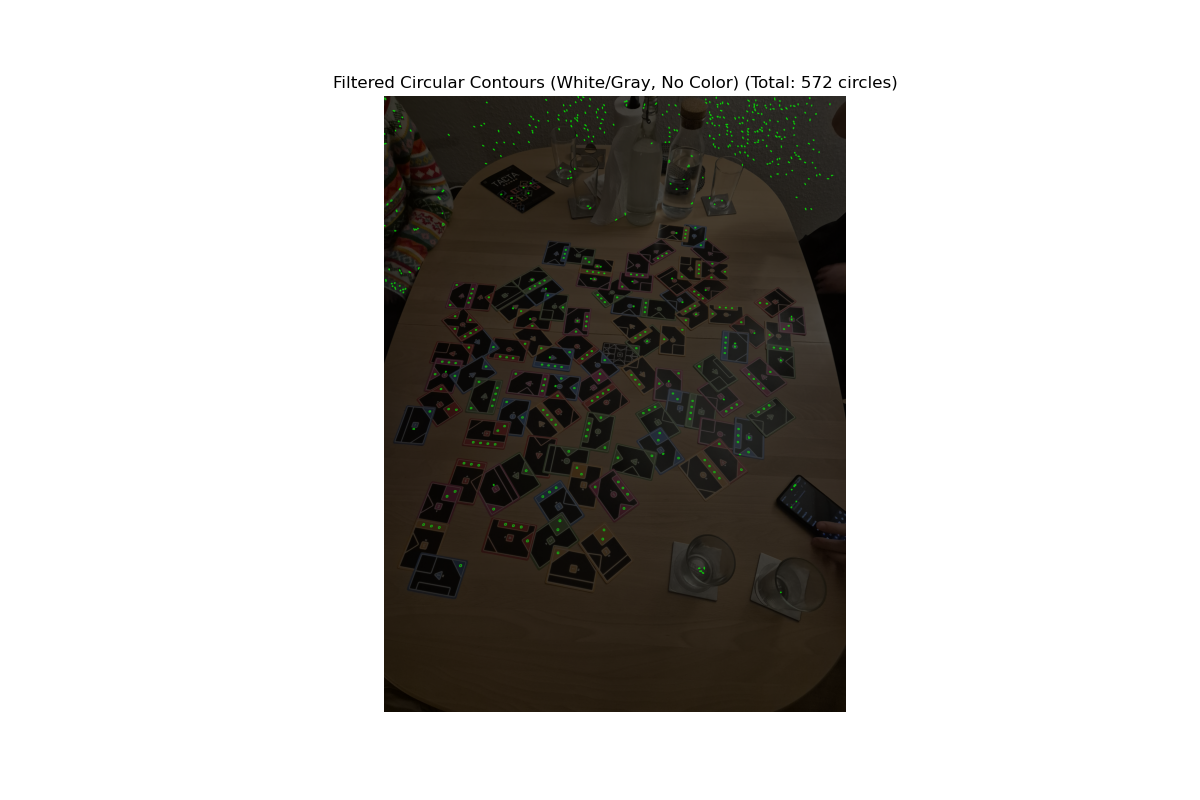

Found 572 circles matching criteria


In [6]:
# Filter contours to find circles with diameter 9-15 and white/gray fill (no color)
filtered_contours = []
min_diameter = 8
max_diameter = 18
min_radius = min_diameter / 2
max_radius = max_diameter / 2

# Thresholds
max_std_dev_threshold = 20
# low saturation means gray/white (no color)
max_saturation = 80  # Easy to change: lower = more strict (0-255 scale)

# Convert to HSV for saturation check
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

# For visualization
i = 0
fig = plt.figure(figsize=(17, 6))
ncols, nrows = 20, 4
subfigs = fig.subfigures(nrows, ncols)
j = 0


def render_contour_subfigures(
    filtered_contours,
    subfigs,
    contour,
    x,
    y,
    radius,
    mean_intensity,
    std_intensity,
    mean_saturation,
    meets_filter_criteria,
    meets_intensity_threshold,
    is_variance_acceptable,
):
    global i, j
    i += 1

    if i % 1 == 0 and j < ncols * nrows:
        # Get bounding box
        x_int, y_int = int(x), int(y)
        r_int = int(radius)

        # Define crop region with padding
        padding = 10
        y1 = max(0, y_int - r_int - padding)
        y2 = min(image_rgb.shape[0], y_int + r_int + padding)
        x1 = max(0, x_int - r_int - padding)
        x2 = min(image_rgb.shape[1], x_int + r_int + padding)

        # Crop the region
        cropped_img = image_rgb[y1:y2, x1:x2].copy()

        # Dim the image
        dimmed = (cropped_img * 0.4).astype(np.uint8)

        # Adjust contour coordinates for cropped image
        contour_shifted = contour - [x1, y1]

        # Draw contour on dimmed image
        color = (0, 255, 0, 150) if meets_filter_criteria else (255, 0, 0, 150)
        cv2.drawContours(dimmed, [contour_shifted], -1, color, 1)

        # Create subplot
        subfig = subfigs[j // ncols, j % ncols]
        ax = subfig.add_subplot(1, 1, 1)
        ax.imshow(dimmed)
        ax.axis("off")
        ax.set_title(
            (
                f"#{i} / {len(filtered_contours)}\n"
                f"μ={mean_intensity:.0f}, σ={std_intensity:.0f}\n"
                f"sat={mean_saturation:.0f}\n"
                f"meets={meets_filter_criteria}\n"
                f"intensity={meets_intensity_threshold}\n"
                f"variance={is_variance_acceptable}\n"
                f"saturation={mean_saturation:.0f} {mean_saturation < max_saturation}"
            ),
            fontsize=6,
        )
        j += 1


for contour in contours:
    # Calculate contour area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Get minimum enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(contour)

    # Calculate circularity (1.0 is perfect circle)
    if perimeter == 0:
        continue

    circularity = 4 * np.pi * area / (perimeter * perimeter)

    # print(f"Contour at ({x:.1f}, {y:.1f}) with radius {radius:.1f} and circularity {circularity:.2f}, area {area:.1f}, perimeter {perimeter:.1f}")

    # if not( 50 <= y <= 1300 and 2400 <= x <= 3400):
    #     continue

    # Skip very small contours
    if area < 30 or perimeter <= 10:
        continue

    # Check if it's circular enough
    if circularity <= 0.4:
        continue

    # Check if diameter is in range
    if not (min_radius <= radius <= max_radius):
        continue

    # Create mask for the circle region
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.circle(mask, (int(x), int(y)), int(radius)-2, 255, -1)

    # Extract the region from original grayscale image
    pixels = gray[mask == 255]

    # Check if region is relatively white/gray (high intensity)
    mean_intensity = pixels.mean()
    std_intensity = pixels.std()
    
    # Extract HSV region to check saturation (color)
    hsv_masked = cv2.bitwise_and(image_hsv, image_hsv, mask=mask)
    saturation_values = hsv_masked[:, :, 1][mask == 255]
    mean_saturation = np.mean(saturation_values)

    meets_intensity_threshold = mean_intensity > 100
    is_variance_acceptable = std_intensity < max_std_dev_threshold
    saturation_meets_threshold = mean_saturation < max_saturation
    meets_filter_criteria = (
        meets_intensity_threshold
        and is_variance_acceptable
        and saturation_meets_threshold
    )
    render_contour_subfigures(
        filtered_contours,
        subfigs,
        contour,
        x,
        y,
        radius,
        mean_intensity,
        std_intensity,
        mean_saturation,
        meets_filter_criteria,
        meets_intensity_threshold,
        is_variance_acceptable,
    )

    # Filter: high intensity, low std deviation, AND low saturation (no color)
    if meets_filter_criteria:
        filtered_contours.append(contour)

plt.tight_layout()
plt.show()

# Visualize all filtered contours on full image
filtered_image = darkened_image.copy()
cv2.drawContours(filtered_image, filtered_contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(filtered_image)
plt.axis("off")
plt.title(
    f"Filtered Circular Contours (White/Gray, No Color) (Total: {len(filtered_contours)} circles)"
)
plt.show()

print(f"Found {len(filtered_contours)} circles matching criteria")

In [7]:
hsv_colors = []

for contour in filtered_contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    circle_inner = cv2.circle(np.zeros_like(gray), (int(x), int(y)), int(radius)+1, 255, -1)
    circle_outer = cv2.circle(np.zeros_like(gray), (int(x), int(y)), int(radius)+6, 0, -1)
    donut = circle_inner - circle_outer
    mean_hsv = cv2.mean(image_hsv, mask=donut)
    hsv_colors.append(mean_hsv)

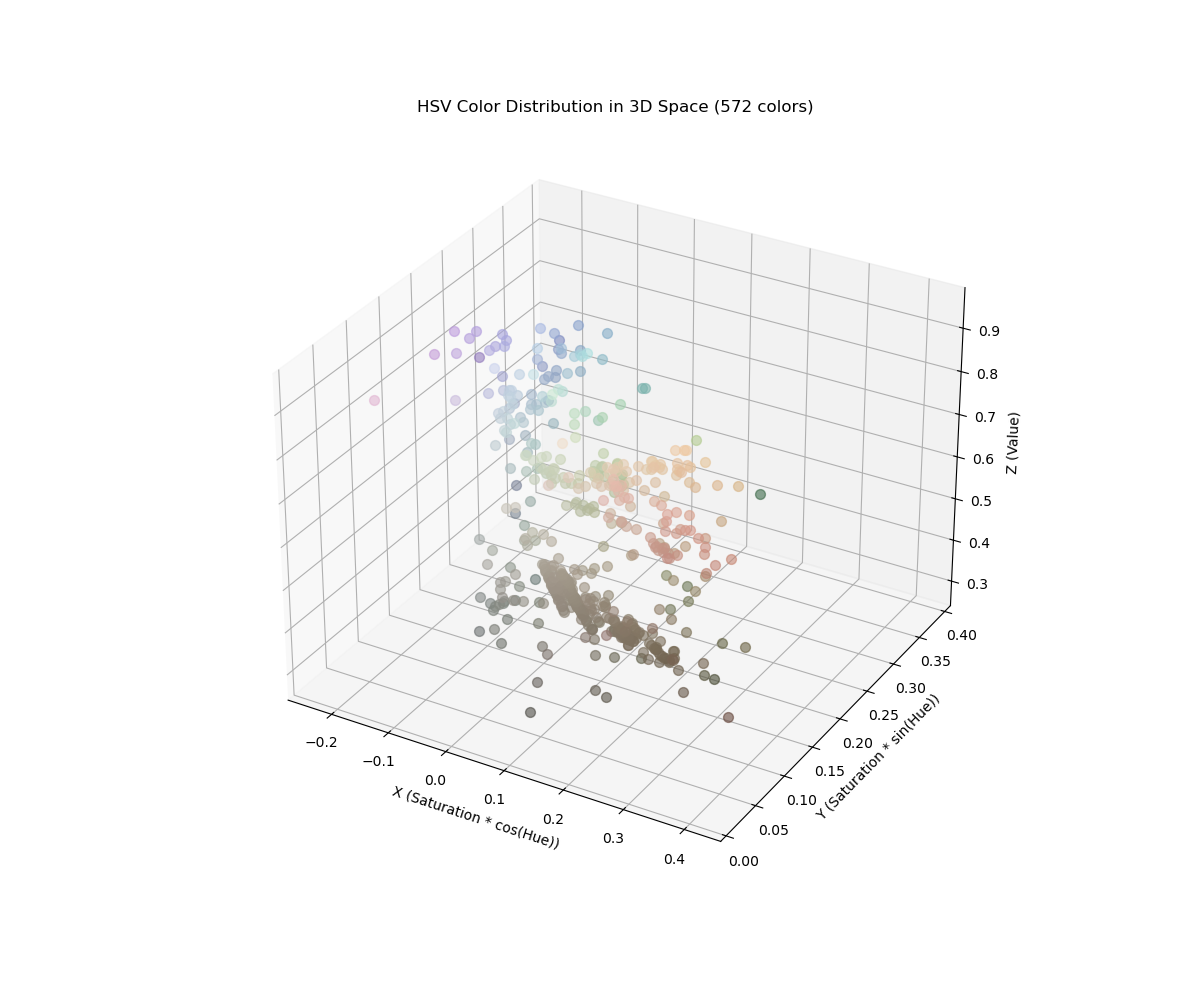

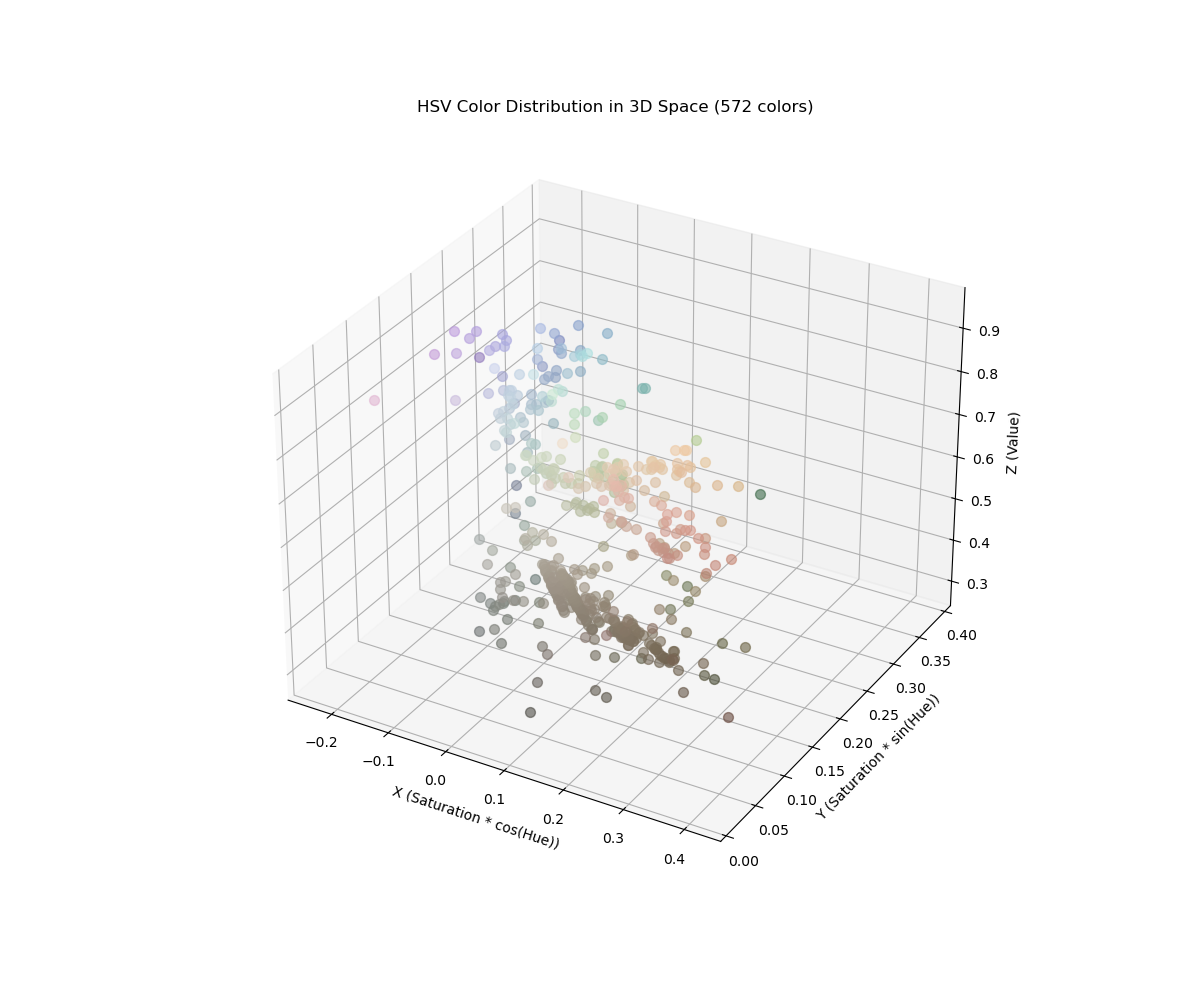

In [ ]:
# Convert HSV colors to Cartesian coordinates for 3D plotting
# HSV is in cylindrical coordinates: H (hue) is angle, S (saturation) is radius, V (value) is height
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for hsv in hsv_colors:
	h, s, v = hsv[0], hsv[1], hsv[2]
	
	# Convert HSV to cylindrical coordinates
	# H is in [0, 180] for OpenCV, normalize to [0, 2π]
	angle = (h / 180.0) * np.pi
	
	# S is in [0, 255], normalize to [0, 1]
	radius = s / 255.0
	
	# V is in [0, 255], normalize to [0, 1]
	height = v / 255.0
	
	# Convert to Cartesian coordinates
	x = radius * np.cos(angle)
	y = radius * np.sin(angle)
	z = height
	
	# Convert HSV to RGB for point color
	hsv_normalized = np.uint8([[[h, s, v]]])
	rgb = cv2.cvtColor(hsv_normalized, cv2.COLOR_HSV2RGB)[0][0]
	color = rgb / 255.0
	
	ax.scatter(x, y, z, c=[color], s=50, alpha=0.6)

ax.set_xlabel('X (Saturation * cos(Hue))')
ax.set_ylabel('Y (Saturation * sin(Hue))')
ax.set_zlabel('Z (Value)')
ax.set_title(f'HSV Color Distribution in 3D Space ({len(hsv_colors)} colors)')

plt.show()


In [9]:
# plot all of the hsv colors in a hsv sphere
